In [53]:
#Load the iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target


from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target

In [388]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=5000,n_features=5 ,centers=5, random_state=123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [372]:
from sklearn.datasets import make_classification
X,y=make_classification(n_samples=10000,n_features=10,n_classes=5,n_clusters_per_class=1,n_informative=4,n_redundant=4,random_state=123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [310]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
#Randomly select 10000 samples from the training set
X_train, y_train = X_train[:20000], y_train[:20000]
X_test, y_test = X_test[:2000], y_test[:2000]

In [311]:
#Convert the data into numpy.ndarray
import numpy as np
X= np.array(X)
y = y.to_numpy().astype(int)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train=y_train.astype(int)
y_test=y_test.astype(int)

In [312]:
print(type(X_test[0][0]))

<class 'numpy.int64'>


In [362]:
import numpy as np
from collections import defaultdict
import time
import tracemalloc

class LSH_KNN:
    def __init__(self,X,y,n_neighbors=5,n_hyperplanes=3):
        self.X = X
        self.y = y
        self.n_hyperplanes=n_hyperplanes
        self.n_neighbors =n_neighbors
        self.hyperplanes = None
        self.bias=None
        self.buckets = defaultdict(list)
        self.labels = None
    
    def fit(self):
        self.labels = self.y
        n_samples, n_features = self.X.shape
        self.hyperplanes = np.random.normal(size=(self.n_hyperplanes, n_features))
        self.bias = np.random.uniform(0, 2 * np.pi, self.n_hyperplanes)
        for i in range(n_samples):
            hash_val = self.hash(self.X[i])
            self.buckets[hash_val].append(i)
    
    def predict(self, X):
        n_samples = X.shape[0]
        y_pred = []
        for i in range(n_samples):
            neighbors = self.find_nearest_neighbors(X[i])
            if len(neighbors) == 0:
            # No neighbors found, assign a random label 
                y_pred.append(np.random.choice(np.unique(self.labels)))
            else:    
                neighbors = np.array(neighbors, dtype=int)
                labels = self.labels[neighbors]
                unique, counts = np.unique(labels, return_counts=True)
                y_pred.append(unique[np.argmax(counts)])
        return np.array(y_pred)
    
    def hash(self, x):
        hash_val = ""
        for i in range(self.n_hyperplanes):
            dot_product = np.dot(self.hyperplanes[i], x) + self.bias[i]
            hash_val += "1" if dot_product >= 0 else "0"
        return hash_val
    
    def find_nearest_neighbors(self, x):
        hash_val = self.hash(x)
        candidate_indices = []
        if(self.buckets[hash_val] is not None):
            candidate_indices=self.buckets[hash_val]
        candidate_indices = np.unique(candidate_indices)
        distances = [np.linalg.norm(x - X[i]) for i in candidate_indices]
        nearest_neighbors = np.argsort(distances)[:self.n_neighbors]
        return candidate_indices[nearest_neighbors]
    
    def give_hyperplanes(self):
        return self.hyperplanes

start_time = time.time()
tracemalloc.start()

lsh_knn = LSH_KNN(X_train,y_train,n_hyperplanes=17)

lsh_knn.fit()
train_end_time = time.time()

print("Memory usage: ", tracemalloc.get_traced_memory()[1], "bytes")

tracemalloc.stop()

# y_pred = lsh_knn.predict(X_test)

test_end_time = time.time()

# print("Accuracy: ", np.mean(y_pred == y_test))
print("Training time: ", train_end_time - start_time)
print("Testing time: ", test_end_time - train_end_time)

Memory usage:  39144 bytes
Training time:  0.0509185791015625
Testing time:  0.0


In [394]:
accuracy_lsh=[]
random_lsh=[]

In [ ]:
for i in range(2, 10):
    lsh_knn = LSH_KNN(X_train,y_train,n_hyperplanes=i)
    lsh_knn.fit()

    new_X = []
    y_new = []
    weights = []

    buckets = lsh_knn.buckets

    for bucket in buckets:
        # print(bucket)
        if len(buckets[bucket]) == 0:
            continue
        
        avg = np.mean(X[buckets[bucket]], axis=0)
        most_common = np.bincount(y[buckets[bucket]]).argmax()
        weights.append(len(buckets[bucket]))
        new_X.append(avg)
        y_new.append(most_common)
    new_X = np.array(new_X)
    
    mlp_new_data = MLP(X_train.shape[1], 50, len(np.unique(y)))
    mlp_new_data.fit(new_X, y_new,weights)
    y_pred_new_data = mlp_new_data.predict(X_test)
    accuracy=accuracy_score(y_test, y_pred_new_data)
    accuracy_lsh.append(accuracy)
    
    # Select random points equal to len(new_X) and calculate accuracy
    indices = np.random.choice(X_train.shape[0], len(new_X), replace=False)
    X_random = X_train[indices]
    y_random = y_train[indices]
    
    mlp_random = MLP(X_train.shape[1], 50, len(np.unique(y)))
    mlp_random.fit(X_random, y_random,weights)
    y_pred_random = mlp_random.predict(X_test)
    accuracy_random=accuracy_score(y_test, y_pred_random)
    random_lsh.append(accuracy_random)

In [401]:
full_data_accuracy = [0.98]*len(accuracy_lsh)

In [ ]:
#Plot the accuracy vs number of hyperplanes
plt.plot(range(2, 11), full_data_accuracy, label="Full data")
plt.plot(range(2,11), accuracy_lsh, label="LSH Coreset")
plt.plot(range(2, 10), random_lsh, label="Random Coreset" )  
plt.xlabel("Number of hyperplanes")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [363]:
# Now for each bucket in LSH, we take the average of the points in each bucket and append this average to create a new dataset also keep track of y values
new_X = []
y_new = []
weights = []

buckets = lsh_knn.buckets

for bucket in buckets:
    # print(bucket)
    if len(buckets[bucket]) == 0:
        continue
    
    avg = np.mean(X[buckets[bucket]], axis=0)
    most_common = np.bincount(y[buckets[bucket]]).argmax()
    weights.append(len(buckets[bucket]))
    new_X.append(avg)
    y_new.append(most_common)
new_X = np.array(new_X)
print(new_X.shape)
print(len(y_new))

(13, 2)
13


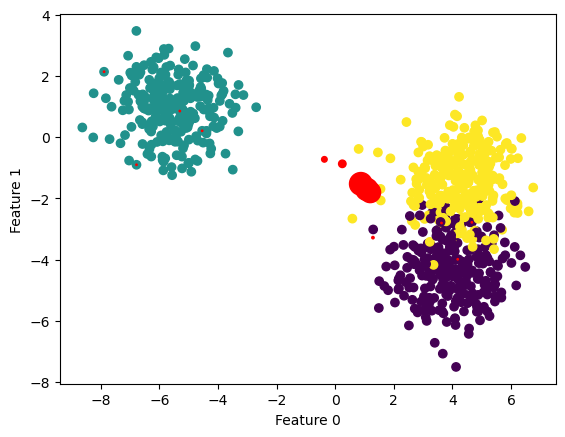

In [369]:
#Plot the selected points in new_X and points in X_train
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis')
#Mark the selected points in new_X in red
plt.scatter(new_X[:, 0], new_X[:, 1], c='red')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.show()

In [308]:
np.mean(weights)

16.89189189189189

In [399]:
#Use the full data and train Neural network on it then train on the new data and compare the results keeping the same test data
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
import time

class MLP(nn.Module):
    def __init__(self,intput_size=28*28, hidden_size=50, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(intput_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x= torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def fit(self, X, y,weights):
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        # for epoch in range(100):
        optimizer.zero_grad()
        
        for epoch in range(2000):
            optimizer.zero_grad()
            output = self.forward(X)
            # for i in range(X.shape[0]):
                # loss = criterion(output[i].view(1,-1), y[i].view(1))
                # print(loss)
                # loss.backward(retain_graph=True)
                # optimizer.step()
                # hash_val = lsh_knn.hash(X)
                # weights = torch.tensor([weights[hash_val[i]] for i in range(len(hash_val))], dtype=torch.float32)
                # print(weights.shape)
            weight = torch.tensor([weights[i] for i in range(len(y))], dtype=torch.float32)
            # print(weight.shape)
            
            loss = criterion(output, y)*weight
            # print(loss.shape)
            loss = loss.mean()
            # print(loss)
            loss.backward()
            optimizer.step()
            
    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            output = self.forward(X)
            return torch.argmax(output, dim=1).numpy()
